- KEYWORDS: scipy.optimize.minimize


## Constrained minimization



So far we have predominantly focused on unconstrained minimization. Sometimes, however, we seek to minimize an objective function and find solutions that meet some kind of constraint.

The volume of a cylindrical can is $V = (\pi/4) D^2 L$. The cost of the top/bottom of the can is \\$0.025 / cm<sup>2</sup>, and the cost of the sides is \\$0.043 / cm<sup>2</sup>. If we require a volume of 355 cm<sup>3</sup>, what is the optimal length and diameter to minimize the cost of the can?

This is a constrained minimization; we want to minimize the cost by changing the height of the can and the diameter of the top while maintaining the volume.

The key to solving this problem is recognizing that the equality constraint means the can length and diameter are not independent because of the equation for the volume. This allows us to solve for one, and then use it in the cost function



# Out [1]:
# text/plain
Text(0, 0.5, 'Cost')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

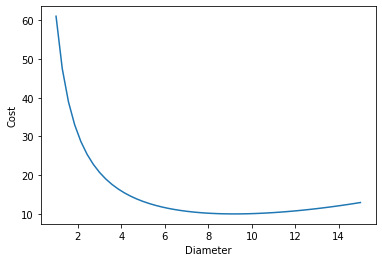

In [1]:
import numpy as np
from scipy.optimize import minimize

V = 355
ct = 0.025  # Cost of the top $/cm**2
cs = 0.043  # Cost of the side $/cm**2

def cost(D):
    radius = D / 2
    top_area = np.pi * radius**2
    top_bottom_cost = 2 * ct * top_area
    L = 4 * V / np.pi / D**2 # solved from the volume
    side_cost = cs * L * np.pi * D
    return top_bottom_cost + side_cost

D = np.linspace(1, 15)
c = cost(D)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(D, c)
plt.xlabel('Diameter')
plt.ylabel('Cost')

In [1]:
sol = minimize(cost, 10)
print(sol)
D, = sol.x
L = 4 * V / np.pi / D**2
print(f'The optimal diameter is {D:1.2f} cm. The optimal length is {L:1.2f} cm. The cost is ${sol.fun:1.2f}.')

# Out [2]:
# output
#+BEGIN_EXAMPLE
      fun: 9.960758701630086
      hess_inv: array([[4.23703911]])
      jac: array([-1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([9.19508297])
The optimal diameter is 9.20 cm. The optimal length is 5.35 cm. The cost is $9.96.
#+END_EXAMPLE

Here we used the method of elimination to solve an *equality constraint* minimization.



### scipy.optimize.minimize with constraints



In other problems, we might simply require some part of the solution to be less than or greater than some number. We call these inequality constraints.

Here we will consider a strategy for solving these kinds of problems.

`scipy.optimize.minimize` can be used with constraints. Before we get to how this is done, we need to introduce a new data type in Python: the dictionary.

A dictionary, also known as a lookup or hash table, is a data structure that allows you to look up values by a key. A dictionary is created with curly brackets {} that contain `key: value` pairs. You can use anything that is "hashable" as a key, and anything as a value. Things that are hashable are: strings, numbers, tuples. You cannot use a list or array; they are mutable and not hashable. Here is an example.



In [1]:
def f(x):
    return x**2

d = {'a': 1,
     'type': 'function',
     'func': f,
     4: 'int',
     5.0: 'float'}

# Out [3]:

Now, we can retrieve data from it like this:



In [1]:
d['a'], d[4], d[5.0]

# Out [4]:
# text/plain
(1, 'int', 'float')

It is usually an error to ask for a key that does not exist.



In [1]:
d['NotHere']

# Out [5]:
# output

KeyErrorTraceback (most recent call last)
<ipython-input-5-e786609d9548> in <module>
----> 1 d['NotHere']

KeyError: 'NotHere'

But, here is a little surprise. The dictionary has a key for 5.0 (a float), but not for 5 (an int):



In [1]:
d[5], d[5.0], hash(5), hash(5.0)

# Out [6]:
# text/plain
('float', 'float', 5, 5)

The integer 5 and float 5.0 hash to the same value, so the dictionary returns something for both of them.

We can get the function, and call it:



In [1]:
d['func'](3)

# Out [7]:
# text/plain
9

The reason we have to consider dictionaries is that `scipy.optimize.minimize` uses dictionaries to specify constraints. See the constraints arg here.



In [1]:
from scipy.optimize import minimize
?minimize

# Out [8]:

We have to write functions that codify the constraints, and then pass them to minimize.



### Equality constraints



We first repeat the problem we did before.

The volume of a cylindrical can is $V = (\pi/4) D^2 L$. The cost of the top/bottom of the can is \\$0.025 / cm<sup>2</sup>, and the cost of the sides is \\$0.043 / cm<sup>2</sup>. If we require a volume of 355 cm<sup>3</sup>, what is the optimal length and diameter to minimize the cost of the can?

We have two variables to modify: $D, L$, but there is an equality constraint in this problem that is described in the volume equation. We codify this in a function that returns zero when the constraint is satisfied. We also define a variable for the constraints dictionary.



In [1]:
import numpy as np

def equality_constraint(x):
    D, L = x
    radius = D / 2
    V = np.pi * radius**2 * L
    return V - 355

constraints = {'type': 'eq', 'fun': equality_constraint}

# Out [9]:

Now, we can setup the objective function with the two variables we want to vary to find the minimum. We still need a guess. The advantage of the previous method of elimination is we had a 1D objective that was easy to plot. Here, we would have to consider a contour plot to see where the minimum is. We just use our previous answer.



In [1]:
cost_top = 0.025  # $/cm^2
cost_side = 0.043 # $/cm^2

def objective(x):
    D, L = x  # Now we vary both variables.
    radius = D / 2
    top_area = np.pi * radius**2
    side_area = L * np.pi * D
    cost = (2 * top_area * cost_top) + (side_area * cost_side)
    return cost

sol = minimize(objective, (9.2, 5), constraints=constraints)
equality_constraint(sol.x)
objective(sol.x)
sol

# Out [10]:
# text/plain
     fun: 9.960758701245243
     jac: array([1.44435978, 1.24215055])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([9.19508759, 5.34597263])

You can have multiple equality constraints, you just make a list of dictionaries. Suppose we seek to minimize $x1 + x2 + x3^2$ subject to the equality constraints $x1=1$, and $x1^2 + x2^2 = 1$. Some analysis suggests that this really means x1=1, x2=0, and then x3 must also be zero to minimize the function, which has a minimum value of 1.

Here we can set this up as a minimization problem:



In [1]:
def objective(x):
    x1, x2, x3 = x
    return x1 + x2 + x3**2

def eq1(x):
    x1, x2, x3 = x
    return x1 - 1   # x = 1

def eq2(x):
    x1, x2, x3 = x
    return x1**2 + x2**2 - 1  # x1**2 + x2**2 = 1

constraints = [{'type': 'eq', 'fun': eq1},
               {'type': 'eq', 'fun': eq2}]

minimize(objective, [0, 0, 0], constraints=constraints)

# Out [11]:
# text/plain
     fun: 1.0000051566408261
     jac: array([ 1.        ,  1.        , -0.00425012])
 message: 'Optimization terminated successfully.'
    nfev: 409
     nit: 65
    njev: 65
  status: 0
 success: True
       x: array([ 1.00000000e+00,  6.40736032e-07, -2.12506583e-03])

As expected, x1=1, and x2 and x3 are near zero. They are not zero because of tolerance. You can make the tolerance tighter, (say tol=1e-9) to see the difference.



### Inequality constraints



Inequality constraints are those where some part of the solution is greater than or less than a value. In `scipy.optimize.minimize` we codify this by writing functions that are non-negative, i.e. **greater than or equal to zero at the solution**.

Maximize $x^3 - 3x$ subject to $x \le 2.5$. First, recall we can rewrite the inequality as $-x \ge -2.5$, and again as $-x + 2.5 \ge 0$. That means for our solution we require $-x+2.5$ to be positive. Also, since we are maximizing the function, our objective is multiplied by -1. When possible, it is always a good idea to visualize the problem:



# Out [12]:


# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

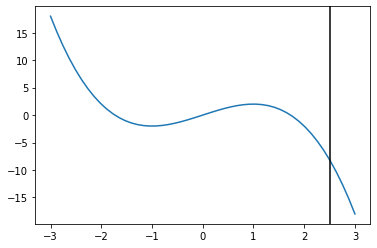

In [1]:
def objective(x):
    return -1 * (x**3 - 3 * x)

%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(-3, 3)
plt.plot(x, objective(x))
plt.axvline(2.5, color='k')

You can see by inspection there is a minimum around x=-1, and at x=2.5. Note the one at x=2.5 is not a minimum in the sense that the derivative=0 there, it is just the smallest value that also satisfies the constraint. To solve this problem, we set up the following code:



In [1]:
def ieq(x):
    return -x + 2.5

constraints = {'type': 'ineq', 'fun': ieq}

minimize(objective, 3, constraints=constraints)

# Out [13]:
# text/plain
     fun: -8.124999999955515
     jac: array([-15.75000012])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([2.5])

Note that there are two solutions. Which one you get depends on your initial guess.



In [1]:
minimize(objective, -0.9, constraints=constraints)

# Out [14]:
# text/plain
     fun: -1.999999999942188
     jac: array([2.63750553e-05])
 message: 'Optimization terminated successfully.'
    nfev: 13
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([-0.99999561])

You have to decide which one is better. In this case, it is the one at x=2.5 which has a higher maximum than the one at x=-1.



### An application



Let us suppose that a merry farmer has 75 roods (4 roods = 1 acre) on which to plant two crops: wheat and corn. To produce these crops, it costs the farmer (for seed, water, fertilizer, etc. ) \\$120 per rood for the wheat, and \\$210 per rood for the corn. The farmer has \\$15,000 available for expenses, but after the harvest the farmer must store the crops while awaiting favorable or good market conditions. The farmer has storage space for 4,000 bushels. Each rood yields an average of 110 bushels of wheat or 30 bushels of corn. If the net profit per bushel of wheat (after all the expenses) is \\$1.30 and for corn is \\$2.00, how should the merry farmer plant the 75 roods to maximize profit?

It is not obvious what to do. Wheat is cheaper to plant, and yields more per rood, but it is less profitable.

Let $x$ be the number of roods of wheat planted, and $y$ be the number of roods of corn planted. The profit function is: $ P = (110)($1.3)x + (30)($2)y = 143x + 60y $

There are some constraint inequalities, specified by the limits on expenses, storage and roodage. They are:

$\$120x + \$210y <= \$15000$ (The total amount spent cannot exceed the amount the farm has)

$110x + 30y <= 4000$ (The amount generated should not exceed storage space.)

$x + y <= 75$ (We cannot plant more space than we have.)

$0 <= x$ and $0 <= y $ (all amounts of planted land must be positive.)

To solve this problem, we cast it as minimization problem, which minimizes a function f(X) subject to some constraints. We create a proxy function for the negative of profit, which we seek to minimize.

Note we use inequality constraints here. You could put some as equality, e.g. if you want to make sure you spend all $15000, or if you want to ensure you fill up your storage. It could be a mistake to require both of those though, as it may be infeasible.



In [1]:
def c1(X):
    'Constraint on total cost to plant.'
    x, y = X
    return -(120 * x + 210 * y - 15000)

def c2(X):
    'Storage constraint'
    x, y = X
    return -(110 * x + 30 * y - 4000)

def c3(X):
    'Land area constraint'
    x, y = X
    return -(x + y - 75)

def c4(X):
    'positivity constraint'
    return X[0]

def c5(X):
    'positivity constraint'
    return X[1]

def profit(X):
    'Profit function'
    x, y = X
    return -(143 * x + 60 * y)

sol = minimize(profit, [60, 15], constraints=[{'type': 'ineq', 'fun': f} for f in [c1, c2, c3, c4, c5]])
sol

# Out [15]:
# text/plain
     fun: -6315.624999538349
     jac: array([-143.,  -60.])
 message: 'Optimization terminated successfully.'
    nfev: 13
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([21.875, 53.125])

In [1]:
print(f'We should plant {sol.x[0]:1.2f} roods of wheat, and {sol.x[1]:1.2f} roods of corn. We will earn ${-sol.fun:1.2f} in profit.')

# Out [16]:
# output
We should plant 21.87 roods of wheat, and 53.12 roods of corn. We will earn $6315.62 in profit.

We can always verify aspects of our solution. Here is the land area.



In [1]:
print(f'We used {np.sum(sol.x):1.2f} roods of land')

# Out [17]:
# output
We used 75.00 roods of land

In [1]:
print(f'We will pay ${sol.x[0]*120 + sol.x[1]*210:1.2f} to plant.')
print(f'We will store {sol.x[0] * 110 + sol.x[1] * 30:1.0f} bushels.')

# Out [18]:
# output
We will pay $13781.25 to plant.
We will store 4000 bushels.

You can see we did not need to spend all the money because we do not have enough storage space to accommodate more crops. It would be a mistake to make these both equality constraints, because then there would be no feasible solution.



### Summary



`scipy.optimize.minimize` provides a convenient interface to solving a broad set of optimization problems both unconstrained and constrained. There is a significant body of knowledge hidden from us under this interface. For example there are 14 choices for different optimization algorithms in the interface, and the default one is chosen for you depending on arguments passed to it. It is easy to tell if the defaults are suitable; if you get a solution they are. If you don't get a solution, then you have to assess whether there is a solution, and whether a better algorithm would be appropriate. The details of these algorithms are the subject of dedicated courses in optimization.

